In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GroupKFold
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV, Lasso
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('feature_data/weekly_features.csv')
df.dtypes

year_week                          object
week_start_date                    object
coffee_name                        object
weekly_revenue                    float64
weekly_transactions                 int64
avg_transaction_value             float64
transaction_value_volatility      float64
month_first                         int64
week_of_year_first                  int64
hour_of_day_mean                  float64
hour_of_day_std                   float64
hour_of_day_min                     int64
hour_of_day_max                     int64
dominant_day_of_week                int64
weekend_sales_proportion          float64
dominant_time_of_day               object
dominant_weekday                   object
coffee_encoded                      int64
prev_week_revenue                 float64
prev_week_transactions            float64
prev_2week_revenue                float64
prev_3week_revenue                float64
prev_2week_transactions           float64
prev_3week_transactions           

### Data Prep for LightGBM training for Weekly Revenue prediction by Coffee Name

In [3]:
weekly_features = df.copy()

training_features = [
    # Coffee identifier
    'coffee_encoded',
    
    # lag features
    'prev_week_revenue', 'prev_week_transactions',
    'prev_2week_revenue', 'prev_3week_revenue', 
    'prev_2week_transactions', 'prev_3week_transactions',
    
    # Temporal features
    'month_first', 'week_of_year_first', 'dominant_day_of_week',
    'week_of_year_sin', 'week_of_year_cos', 'month_sin', 'month_cos',
    
    # Sales pattern features
    'weekend_sales_proportion', 'hour_of_day_mean', 'hour_of_day_std',
    'hour_of_day_min', 'hour_of_day_max',
    
    # rolling features
    'revenue_4w_mean', 'revenue_4w_std', 'transactions_4w_mean',
    'revenue_8w_mean', 'revenue_12w_mean',
    'transactions_8w_mean', 'transactions_12w_mean',
    
    # Historical seasonal comparisons
    'revenue_same_week_4w_ago', 'revenue_same_week_8w_ago',
    
    # interaction features
    'prev_revenue_x_month', 'prev_revenue_x_week_of_year',
    'transactions_x_weekend_prop', 'coffee_month_interaction',
    'weekend_proportion_interaction'
]

In [4]:
X_weekly = weekly_features[training_features]
y_weekly = weekly_features['weekly_revenue']  # Target: weekly revenue
coffee_names_weekly = weekly_features['coffee_name']
dates_weekly = pd.to_datetime(weekly_features['week_start_date'])

# Remove rows with missing target values (first few weeks due to lag features)
valid_mask = (weekly_features['prev_week_revenue'] != 0) | (weekly_features['weekly_revenue'] > 0)
X_clean = X_weekly[valid_mask].copy()
y_clean = y_weekly[valid_mask].copy()

### Univariate Feature Selection

In [5]:
# Select best features using recursive feature elimination
# Tests each feature individually against the target and calculated F-stat (linear relationship)
print(f"Prior to univariate feature selection, there are {len(training_features)} features")
selector = SelectKBest(score_func=f_regression, k=25)
X_selected = selector.fit_transform(X_clean, y_clean)
selected_features = [training_features[i] for i in selector.get_support(indices=True)]

print(f"Top {len(selected_features)} features selected:")
for feature in selected_features:
    print(f"  • {feature}")

Prior to univariate feature selection, there are 33 features
Top 25 features selected:
  • coffee_encoded
  • prev_week_revenue
  • prev_week_transactions
  • prev_2week_revenue
  • prev_3week_revenue
  • prev_2week_transactions
  • dominant_day_of_week
  • week_of_year_cos
  • month_cos
  • weekend_sales_proportion
  • hour_of_day_std
  • hour_of_day_min
  • hour_of_day_max
  • revenue_4w_mean
  • revenue_4w_std
  • transactions_4w_mean
  • revenue_8w_mean
  • revenue_12w_mean
  • transactions_8w_mean
  • transactions_12w_mean
  • revenue_same_week_4w_ago
  • revenue_same_week_8w_ago
  • transactions_x_weekend_prop
  • coffee_month_interaction
  • weekend_proportion_interaction


In [6]:
# reset X_weekly and X_clean based on selected features
X_weekly =  weekly_features[selected_features]
X_clean = X_weekly[valid_mask].copy()

In [7]:
coffee_clean = coffee_names_weekly[valid_mask].copy()
dates_clean = dates_weekly[valid_mask].copy()

print(f"Weekly dataset shape: {X_clean.shape}")
print(f"Date range: {dates_clean.min()} to {dates_clean.max()}")
print(f"Coffee types: {coffee_clean.nunique()}")
print(f"Target variable (weekly revenue) statistics:")
print(y_clean.describe())

print(f"\nWeekly features prepared for LightGBM training:")
print(f"Features: {len(X_weekly.columns)}")
print(f"Samples: {len(X_clean)}")

Weekly dataset shape: (641, 25)
Date range: 2024-02-26 00:00:00 to 2025-03-17 00:00:00
Coffee types: 8
Target variable (weekly revenue) statistics:
count     641.000000
mean      175.110109
std       181.401009
min        18.120000
25%        38.700000
50%       107.280000
75%       232.200000
max      1144.320000
Name: weekly_revenue, dtype: float64

Weekly features prepared for LightGBM training:
Features: 25
Samples: 641


In [8]:
# Final check for correlations with target to ensure no target leakage
numeric_X_clean = X_clean.select_dtypes(include=[np.number])
feature_correlations = numeric_X_clean.corrwith(y_clean).abs().sort_values(ascending=False)
print(" Feature correlations w/ target")
print(feature_correlations)

 Feature correlations w/ target
prev_2week_revenue                0.591557
prev_2week_transactions           0.584694
hour_of_day_max                   0.499432
hour_of_day_min                   0.482010
hour_of_day_std                   0.481886
revenue_4w_std                    0.455656
revenue_same_week_4w_ago          0.429597
weekend_sales_proportion          0.414482
revenue_12w_mean                  0.409847
revenue_8w_mean                   0.408416
transactions_12w_mean             0.395583
revenue_4w_mean                   0.392420
transactions_8w_mean              0.390958
transactions_4w_mean              0.375397
dominant_day_of_week              0.369926
revenue_same_week_8w_ago          0.318128
weekend_proportion_interaction    0.314782
transactions_x_weekend_prop       0.280933
coffee_encoded                    0.157588
coffee_month_interaction          0.117623
prev_week_transactions            0.102678
prev_week_revenue                 0.077888
month_cos             

In [9]:
lgb_params = {
    'objective': 'regression',
    'metric': ['rmse', 'mae'],
    'boosting_type': 'gbdt',
    'num_leaves': 100,          # Increased complexity
    'learning_rate': 0.02,      # Lower for better convergence
    'feature_fraction': 0.9,    # Use more features
    'bagging_fraction': 0.9,
    'bagging_freq': 3,
    'min_child_samples': 5,     # Allow smaller splits
    'min_child_weight': 1e-4,
    'reg_alpha': 0.01,         # Less regularization
    'reg_lambda': 0.01,
    'max_depth': 12,           # Deeper trees
    'min_split_gain': 0.01,
    'random_state': 42,
    'verbose': -1,
    'force_col_wise': True
}

In [11]:
"""
Fold 1: Train on first 40% → Validate on next 15% (samples 40-55%)
Fold 2: Train on first 55% → Validate on next 15% (samples 55-70%)
Fold 3: Train on first 70% → Validate on next 15% (samples 70-85%)
Fold 4: Train on first 85% → Validate on next 15% (samples 85-100%)
"""

def chronological_time_series_split(X, y, dates, n_splits=4):
    """Create chronological time series splits with expanding training windows."""
    # Sort by date
    date_order = dates.argsort()
    sorted_indices = X.index[date_order]
    
    n_samples = len(sorted_indices)
    initial_train_size = int(n_samples * 0.4)  # Start with 40% for training
    val_window_size = int(n_samples * 0.15)    # 15% for each validation window
    
    splits = []
    for fold in range(n_splits):
        # Expanding training window
        train_end = initial_train_size + (fold * val_window_size)
        val_start = train_end
        val_end = val_start + val_window_size
        
        if val_end > n_samples:
            break
            
        # Get indices
        train_indices = sorted_indices[:train_end]
        val_indices = sorted_indices[val_start:val_end]
        
        # Convert to positions in original dataframe
        train_positions = np.where(X.index.isin(train_indices))[0]
        val_positions = np.where(X.index.isin(val_indices))[0]
        
        splits.append((train_positions, val_positions))
    
    return splits

# Get chronological splits
splits = chronological_time_series_split(numeric_X_clean, y_clean, dates_clean, n_splits=4)

In [13]:
# Store results
fold_scores = []
fold_predictions = []
fold_models = []
fold_feature_importance = []

print(f"Performing chronological time series cross validation...")
print(f"Total folds: {len(splits)}")
print()

# Only use numeric columns
X_clean_numeric = X_clean.select_dtypes(include=[np.number])

for fold_idx, (train_idx, val_idx) in enumerate(splits):
    fold_num = fold_idx + 1
    print(f"Training Fold {fold_num}/{len(splits)}...")
    
    # Split data
    X_train, X_val = X_clean_numeric.iloc[train_idx], X_clean_numeric.iloc[val_idx]
    y_train, y_val = y_clean.iloc[train_idx], y_clean.iloc[val_idx]
    
    # Show date ranges for this fold
    train_dates_fold = dates_clean.iloc[train_idx]
    val_dates_fold = dates_clean.iloc[val_idx]
    train_coffees_fold = coffee_clean.iloc[train_idx].unique()
    val_coffees_fold = coffee_clean.iloc[val_idx].unique()
    
    print(f"  Training: {train_dates_fold.min().strftime('%Y-%m-%d')} to {train_dates_fold.max().strftime('%Y-%m-%d')} ({len(X_train)} samples)")
    print(f"  Validation: {val_dates_fold.min().strftime('%Y-%m-%d')} to {val_dates_fold.max().strftime('%Y-%m-%d')} ({len(X_val)} samples)")
    print(f"  Coffee types: {len(train_coffees_fold)} in training, {len(val_coffees_fold)} in validation")
    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
    
    # Train model
    model = lgb.train(
        lgb_params,
        train_data,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'val'],
        num_boost_round=1000,
        callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
    )
    
    # Make predictions
    val_pred = model.predict(X_val)
    
    # Calculate metrics
    mae = mean_absolute_error(y_val, val_pred)
    rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    r2 = r2_score(y_val, val_pred)
    
    # Store results
    fold_scores.append({
        'fold': fold_num,
        'mae': mae,
        'rmse': rmse,
        'r2': r2,
        'train_samples': len(X_train),
        'val_samples': len(X_val),
        'train_date_range': f"{train_dates_fold.min().strftime('%Y-%m-%d')} to {train_dates_fold.max().strftime('%Y-%m-%d')}",
        'val_date_range': f"{val_dates_fold.min().strftime('%Y-%m-%d')} to {val_dates_fold.max().strftime('%Y-%m-%d')}"
    })
    
    fold_predictions.append({
        'fold': fold_num,
        'val_idx': val_idx,
        'y_true': y_val,
        'y_pred': val_pred,
        'coffee_names': coffee_clean.iloc[val_idx]
    })
    
    fold_models.append(model)
    fold_feature_importance.append(model.feature_importance(importance_type='gain'))
    
    print(f"  MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.3f}")
    print()

# Results summary
scores_df = pd.DataFrame(fold_scores)
print(f"Chronological Time Series Cross-Validation Results")
print(f"Average MAE: {scores_df['mae'].mean():.2f} ± {scores_df['mae'].std():.2f}")
print(f"Average RMSE: {scores_df['rmse'].mean():.2f} ± {scores_df['rmse'].std():.2f}")
print(f"Average R²: {scores_df['r2'].mean():.3f} ± {scores_df['r2'].std():.3f}")

print(f"\n Detailed fold results:")
display_cols = ['fold', 'mae', 'rmse', 'r2', 'train_samples', 'val_samples']
print(scores_df[display_cols].round(3))

Performing chronological time series cross validation...
Total folds: 4

Training Fold 1/4...
  Training: 2024-02-26 to 2024-08-05 (256 samples)
  Validation: 2024-08-12 to 2024-09-30 (96 samples)
  Coffee types: 8 in training, 8 in validation
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[216]	train's rmse: 25.5226	train's l1: 8.52969	val's rmse: 116.377	val's l1: 69.6671
  MAE: 69.67, RMSE: 116.38, R²: 0.602

Training Fold 2/4...
  Training: 2024-02-26 to 2024-09-30 (352 samples)
  Validation: 2024-09-30 to 2024-11-25 (96 samples)
  Coffee types: 8 in training, 8 in validation
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[216]	train's rmse: 25.5226	train's l1: 8.52969	val's rmse: 116.377	val's l1: 69.6671
  MAE: 69.67, RMSE: 116.38, R²: 0.602

Training Fold 2/4...
  Training: 2024-02-26 to 2024-09-30 (352 samples)
  Validation: 2024-09-30 to 2024-11-25 (96 samples)
  Coffee types: 8 i

In [14]:
# Performance by coffee type
all_predictions = []
for pred_data in fold_predictions:
    for i, idx in enumerate(pred_data['val_idx']):
        all_predictions.append({
            'fold': pred_data['fold'],
            'index': idx,
            'coffee_name': pred_data['coffee_names'].iloc[i],
            'y_true': pred_data['y_true'].iloc[i],
            'y_pred': pred_data['y_pred'][i]
        })

pred_df = pd.DataFrame(all_predictions)

# Calculate MAPE for business relevance
def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Performance by coffee type
coffee_performance = pred_df.groupby('coffee_name').apply(
    lambda x: pd.Series({
        'samples': len(x),
        'avg_actual_revenue': x['y_true'].mean(),
        'avg_predicted_revenue': x['y_pred'].mean(),
        'mae': mean_absolute_error(x['y_true'], x['y_pred']),
        'rmse': np.sqrt(mean_squared_error(x['y_true'], x['y_pred'])),
        'r2': r2_score(x['y_true'], x['y_pred']),
        'mape': calculate_mape(x['y_true'], x['y_pred']),
        'prediction_bias': (x['y_pred'].mean() - x['y_true'].mean()) / x['y_true'].mean() * 100
    })
).round(3)

# Sort by R² score (best performing first)
coffee_performance_sorted = coffee_performance.sort_values('r2', ascending=False)

print("Performance by Coffee Type (sorted by R²):")
print(coffee_performance_sorted)

print(f"Average R² across all coffee types: {coffee_performance['r2'].mean():.3f}")

Performance by Coffee Type (sorted by R²):
                     samples  avg_actual_revenue  avg_predicted_revenue  \
coffee_name                                                               
Cappuccino              52.0             195.059                186.263   
Americano               54.0             189.084                171.682   
Latte                   54.0             333.903                277.543   
Americano with Milk     55.0             287.303                269.112   
Cortado                 44.0             101.011                117.235   
Cocoa                   43.0             165.573                170.028   
Hot Chocolate           45.0             162.852                169.139   
Espresso                37.0              44.356                 66.739   

                         mae     rmse     r2    mape  prediction_bias  
coffee_name                                                            
Cappuccino            52.426   74.524  0.717  32.949          

In [26]:
# Espresso r2 low?
espresso_data = pred_df[pred_df['coffee_name'] == 'Espresso']
print(f"\nEspresso analysis:")
# print(f"Total samples: {len(espresso_data)}")
# print(f"Folds with Espresso: {espresso_data['fold'].nunique()}")
# print(f"Samples per fold: {espresso_data.groupby('fold').size()}")

variance_analysis = pred_df.groupby('coffee_name').agg({
    'y_true': ['mean', 'std', 'var', 'min', 'max', 'count'],
    'y_pred': ['mean', 'std']
}).round(2)

variance_analysis.columns = ['actual_mean', 'actual_std', 'actual_var', 'actual_min', 'actual_max', 'samples', 
                           'pred_mean', 'pred_std']

# Calculate coefficient of variation (CV) for better comparison
variance_analysis['cv_actual'] = (variance_analysis['actual_std'] / variance_analysis['actual_mean'] * 100).round(1)
variance_analysis['cv_predicted'] = (variance_analysis['pred_std'] / variance_analysis['pred_mean'] * 100).round(1)

# Sort by variance (descending)
variance_analysis_sorted = variance_analysis.sort_values('actual_var', ascending=False)

# print("Variance Statistics (sorted by actual variance):")
# print(variance_analysis_sorted[['actual_mean', 'actual_std', 'actual_var', 'cv_actual', 'actual_min', 'actual_max']])

print(f"\n Coefficient of Variation (CV) Comparison:")
cv_comparison = variance_analysis_sorted[['samples','actual_mean', 'cv_actual', 'cv_predicted']].copy()
print(cv_comparison)

print(f"\n Insights:")
highest_variance_coffee = variance_analysis_sorted.index[0]
lowest_variance_coffee = variance_analysis_sorted.index[-1]
print("1. SAMPLE SIZE EFFECT:\n \
   • Americano: 54 samples (more data → better learning)\n \
   • Espresso: 37 samples (limited data → poor generalization")
print('=> Observe results after final time-series train/test predictions.')


Espresso analysis:

 Coefficient of Variation (CV) Comparison:
                     samples  actual_mean  cv_actual  cv_predicted
coffee_name                                                       
Latte                     54       333.90       84.9          67.8
Americano                 54       189.08      130.2          90.3
Americano with Milk       55       287.30       73.9          59.0
Cocoa                     43       165.57       85.5          70.8
Cappuccino                52       195.06       72.5          55.0
Hot Chocolate             45       162.85       81.5          68.2
Cortado                   44       101.01       68.6          56.6
Espresso                  37        44.36       75.2          70.6

 Insights:
1. SAMPLE SIZE EFFECT:
    • Americano: 54 samples (more data → better learning)
    • Espresso: 37 samples (limited data → poor generalization
=> Observe results after final time-series train/test predictions.


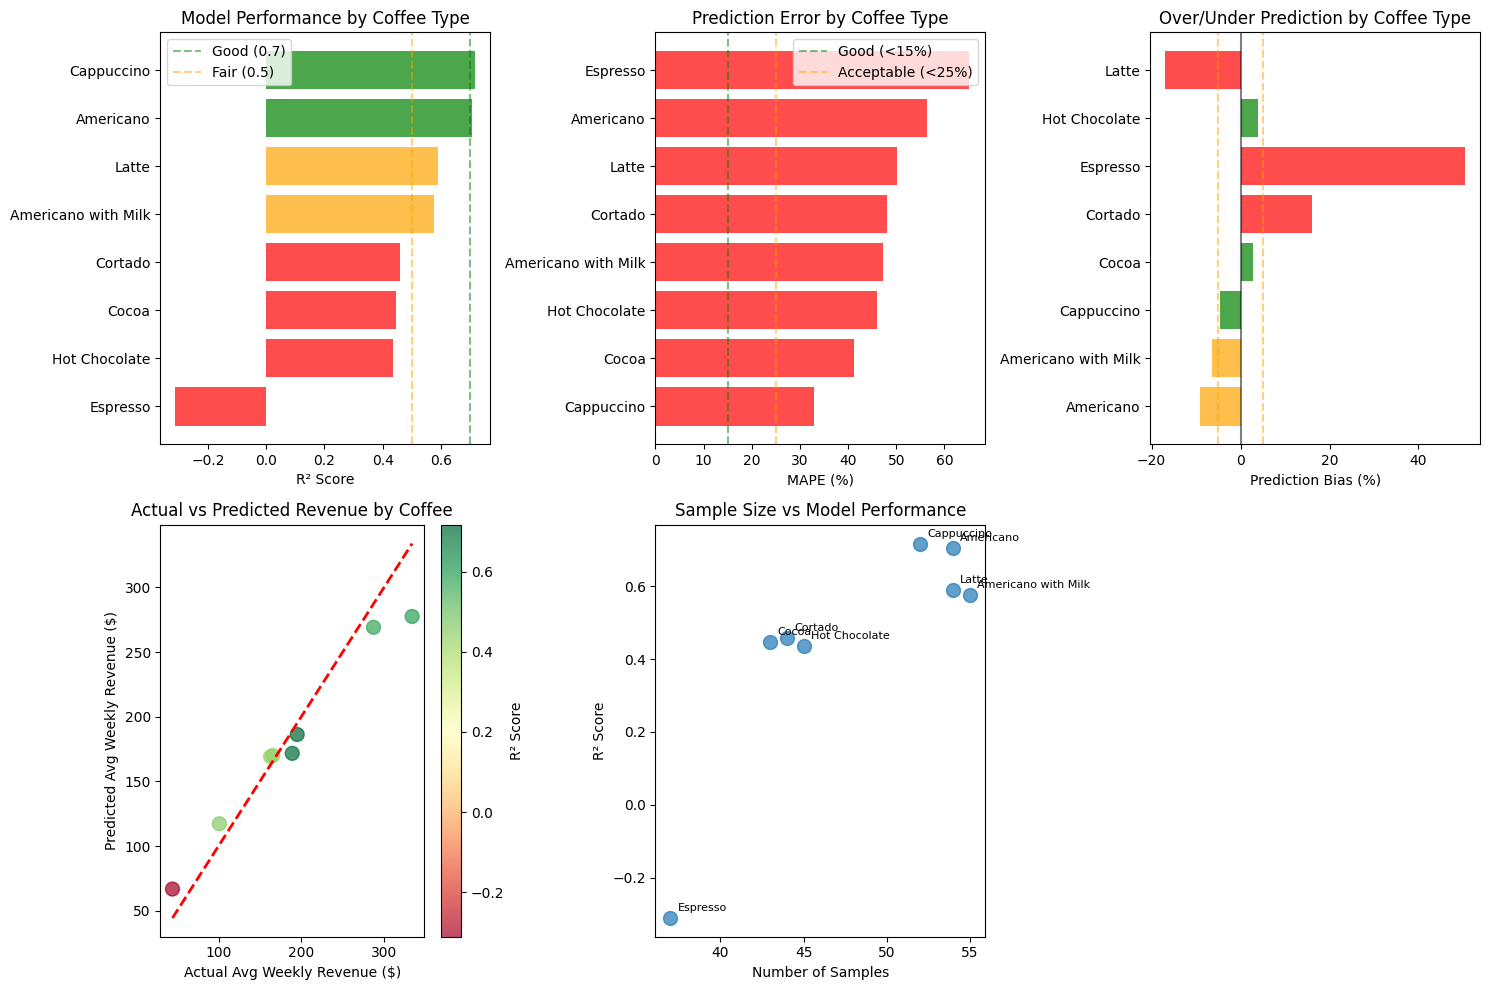

In [27]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
coffee_r2_sorted = coffee_performance.sort_values('r2')
colors = ['red' if x < 0.5 else 'orange' if x < 0.7 else 'green' for x in coffee_r2_sorted['r2']]
plt.barh(range(len(coffee_r2_sorted)), coffee_r2_sorted['r2'], color=colors, alpha=0.7)
plt.yticks(range(len(coffee_r2_sorted)), coffee_r2_sorted.index)
plt.xlabel('R² Score')
plt.title('Model Performance by Coffee Type')
plt.axvline(x=0.7, color='green', linestyle='--', alpha=0.5, label='Good (0.7)')
plt.axvline(x=0.5, color='orange', linestyle='--', alpha=0.5, label='Fair (0.5)')
plt.legend()

plt.subplot(2, 3, 2)
coffee_mape_sorted = coffee_performance.sort_values('mape')
colors = ['green' if x < 15 else 'orange' if x < 25 else 'red' for x in coffee_mape_sorted['mape']]
plt.barh(range(len(coffee_mape_sorted)), coffee_mape_sorted['mape'], color=colors, alpha=0.7)
plt.yticks(range(len(coffee_mape_sorted)), coffee_mape_sorted.index)
plt.xlabel('MAPE (%)')
plt.title('Prediction Error by Coffee Type')
plt.axvline(x=15, color='green', linestyle='--', alpha=0.5, label='Good (<15%)')
plt.axvline(x=25, color='orange', linestyle='--', alpha=0.5, label='Acceptable (<25%)')
plt.legend()

plt.subplot(2, 3, 3)
colors = ['red' if abs(x) > 10 else 'orange' if abs(x) > 5 else 'green' for x in coffee_performance['prediction_bias']]
plt.barh(range(len(coffee_performance)), coffee_performance['prediction_bias'], color=colors, alpha=0.7)
plt.yticks(range(len(coffee_performance)), coffee_performance.index)
plt.xlabel('Prediction Bias (%)')
plt.title('Over/Under Prediction by Coffee Type')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.5)
plt.axvline(x=5, color='orange', linestyle='--', alpha=0.5)
plt.axvline(x=-5, color='orange', linestyle='--', alpha=0.5)

plt.subplot(2, 3, 4)
plt.scatter(coffee_performance['avg_actual_revenue'], coffee_performance['avg_predicted_revenue'], 
           s=100, alpha=0.7, c=coffee_performance['r2'], cmap='RdYlGn')
plt.plot([coffee_performance['avg_actual_revenue'].min(), coffee_performance['avg_actual_revenue'].max()], 
         [coffee_performance['avg_actual_revenue'].min(), coffee_performance['avg_actual_revenue'].max()], 
         'r--', lw=2)
plt.xlabel('Actual Avg Weekly Revenue ($)')
plt.ylabel('Predicted Avg Weekly Revenue ($)')
plt.title('Actual vs Predicted Revenue by Coffee')
plt.colorbar(label='R² Score')

plt.subplot(2, 3, 5)
plt.scatter(coffee_performance['samples'], coffee_performance['r2'], s=100, alpha=0.7)
for i, coffee in enumerate(coffee_performance.index):
    plt.annotate(coffee, (coffee_performance.loc[coffee, 'samples'], 
                         coffee_performance.loc[coffee, 'r2']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)
plt.xlabel('Number of Samples')
plt.ylabel('R² Score')
plt.title('Sample Size vs Model Performance')


plt.tight_layout()
plt.show()

### Training: 2024 → predict 2025 weekly revenue

In [28]:
# Load and prepare data
weekly_features = df.copy()
weekly_features['week_start_date'] = pd.to_datetime(weekly_features['week_start_date'])

# Split data
train_end_date = pd.to_datetime('2024-12-31')
test_start_date = pd.to_datetime('2025-01-01')

# Create time-based train/test split
train_mask = weekly_features['week_start_date'] <= train_end_date
test_mask = weekly_features['week_start_date'] >= test_start_date

train_data = weekly_features[train_mask].copy()
test_data = weekly_features[test_mask].copy()

print(f"Training data: {len(train_data)} samples")
print(f"  Date range: {train_data['week_start_date'].min()} to {train_data['week_start_date'].max()}")
print(f"  Coffee types: {train_data['coffee_name'].nunique()}")

print(f"\nTest data: {len(test_data)} samples")
print(f"  Date range: {test_data['week_start_date'].min()} to {test_data['week_start_date'].max()}")
print(f"  Coffee types: {test_data['coffee_name'].nunique()}")

# Remove rows with missing lag features
train_valid_mask = (train_data['prev_week_revenue'] != 0) | (train_data['weekly_revenue'] > 0)
train_clean = train_data[train_valid_mask].copy()

test_valid_mask = (test_data['prev_week_revenue'] != 0) | (test_data['weekly_revenue'] > 0)
test_clean = test_data[test_valid_mask].copy()

# Prepare training data
X_train = train_clean[selected_features]
y_train = train_clean['weekly_revenue']
coffee_train = train_clean['coffee_name']
dates_train = train_clean['week_start_date']

# Prepare test data
X_test = test_clean[selected_features]
y_test = test_clean['weekly_revenue']
coffee_test = test_clean['coffee_name']
dates_test = test_clean['week_start_date']

print(f"\nCleaned training data: {len(X_train)} samples")
print(f"Cleaned test data: {len(X_test)} samples")

Training data: 517 samples
  Date range: 2024-02-26 00:00:00 to 2024-12-30 00:00:00
  Coffee types: 8

Test data: 124 samples
  Date range: 2025-01-06 00:00:00 to 2025-03-17 00:00:00
  Coffee types: 8

Cleaned training data: 517 samples
Cleaned test data: 124 samples


In [29]:
print(f"\n Training model on 2024 data")
train_data_final = lgb.Dataset(X_train, label=y_train)

final_model = lgb.train(
    lgb_params,
    train_data_final,
    num_boost_round=1000,
    valid_sets=[train_data_final],
    valid_names=['train'],
    callbacks=[lgb.log_evaluation(0)]
)

print(f"\n Predicting 2025 weekly revenue overall...")
predictions_2025 = final_model.predict(X_test)

results_2025 = pd.DataFrame({
    'week_start_date': dates_test,
    'coffee_name': coffee_test,
    'actual_revenue': y_test,
    'predicted_revenue': predictions_2025,
    'prediction_error': predictions_2025 - y_test,
    'absolute_error': np.abs(predictions_2025 - y_test),
    'percentage_error': ((predictions_2025 - y_test) / y_test) * 100
})

# overall 2025 prediction metrics
mae_2025 = mean_absolute_error(y_test, predictions_2025)
rmse_2025 = np.sqrt(mean_squared_error(y_test, predictions_2025))
r2_2025 = r2_score(y_test, predictions_2025)
mape_2025 = np.mean(np.abs((y_test - predictions_2025) / y_test)) * 100

print(f"2025 Prediction Performance:")
print(f"  MAE: ${mae_2025:.2f}")
print(f"  RMSE: ${rmse_2025:.2f}")
print(f"  R²: {r2_2025:.3f}")
print(f"  MAPE: {mape_2025:.1f}%")

# Performance by coffee type for combined 2025 predictions
coffee_performance_2025 = results_2025.groupby('coffee_name').agg({
    'actual_revenue': ['count', 'mean'],
    'predicted_revenue': 'mean',
    'absolute_error': 'mean',
    'percentage_error': ['mean', 'std']
}).round(2)

coffee_performance_2025.columns = ['weeks_predicted', 'avg_actual', 'avg_predicted', 'mae', 'mape_mean', 'mape_std']

print(f"\n2025 performance by coffee type")
print(coffee_performance_2025.sort_values('mape_mean'))


 Training model on 2024 data

 Predicting 2025 weekly revenue overall...
2025 Prediction Performance:
  MAE: $76.67
  RMSE: $127.25
  R²: 0.686
  MAPE: 37.4%

2025 performance by coffee type
                     weeks_predicted  avg_actual  avg_predicted     mae  \
coffee_name                                                               
Cappuccino                        16      261.50         209.67   58.38   
Latte                             17      313.43         254.76   99.08   
Hot Chocolate                     15      164.50         138.43   60.95   
Americano with Milk               19      295.61         237.42   91.75   
Cocoa                             16      216.80         199.21   86.93   
Americano                         20      310.22         237.02  106.88   
Espresso                          13       51.84          66.15   19.85   
Cortado                            8       94.10         149.65   55.55   

                     mape_mean  mape_std  
coffee_name   

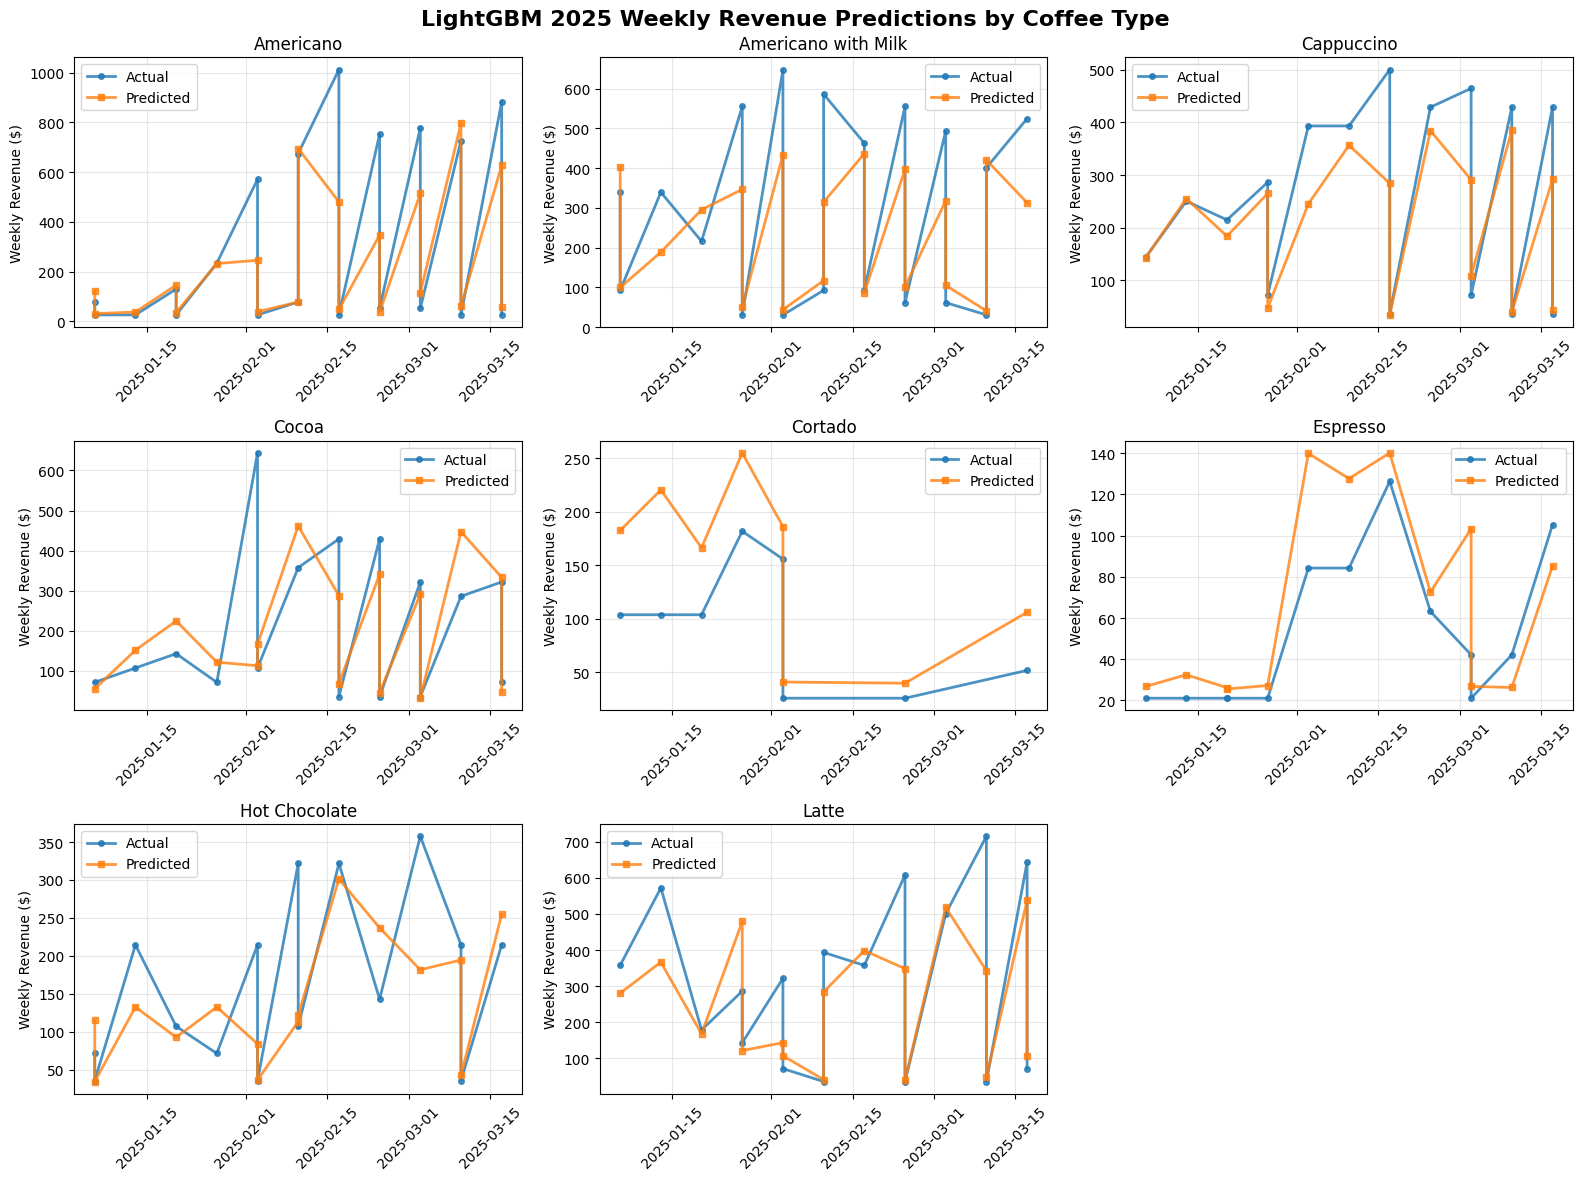

In [30]:
def plot_time_series_predictions(results_df, model_type="Model", figsize=(16, 12)):
    """
    Plot time series predictions for each coffee type.
    
    Parameters:
    results_df: DataFrame with columns ['week_start_date', 'coffee_name', 'actual_revenue', 'predicted_revenue']
    model_type: str, name of the model for the title
    figsize: tuple, figure size
    """
    plt.figure(figsize=figsize)
    
    unique_coffees = results_df['coffee_name'].unique()
    n_coffees = len(unique_coffees)
    cols = 3
    rows = (n_coffees + cols - 1) // cols

    for i, coffee in enumerate(unique_coffees):
        plt.subplot(rows, cols, i + 1)
        
        coffee_data = results_df[results_df['coffee_name'] == coffee].sort_values('week_start_date')
        
        plt.plot(coffee_data['week_start_date'], coffee_data['actual_revenue'], 
                 'o-', label='Actual', linewidth=2, markersize=4, alpha=0.8)
        plt.plot(coffee_data['week_start_date'], coffee_data['predicted_revenue'], 
                 's-', label='Predicted', linewidth=2, markersize=4, alpha=0.8)
        
        plt.title(f'{coffee}')
        plt.ylabel('Weekly Revenue ($)')
        plt.xticks(rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)

    plt.suptitle(f'{model_type} 2025 Weekly Revenue Predictions by Coffee Type', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Plot LightGBM results
plot_time_series_predictions(results_2025, "LightGBM")

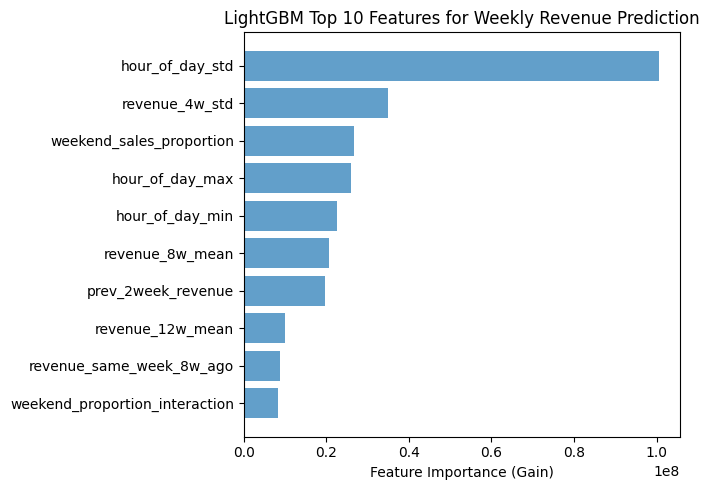

In [42]:
feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': final_model.feature_importance(importance_type='gain')
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(7, 5))
top_features = feature_importance.head(10)
plt.barh(range(len(top_features)), top_features['importance'], alpha=0.7)
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance (Gain)')
plt.title('LightGBM Top 10 Features for Weekly Revenue Prediction')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Train & Predict Separate LightGBM Models per Coffee Type

In [32]:
unique_coffees = coffee_train.unique()
coffee_models = {}
coffee_results_separate = []

for coffee in unique_coffees:
    print(f"Training model for {coffee}...")
    
    # Filter training data for coffee
    coffee_mask_train = coffee_train == coffee
    X_train_coffee = X_train[coffee_mask_train]
    y_train_coffee = y_train[coffee_mask_train]
    
    # Filter test data for coffee
    coffee_mask_test = coffee_test == coffee
    X_test_coffee = X_test[coffee_mask_test]
    y_test_coffee = y_test[coffee_mask_test]
    
    # flag if less than 5 training weeks or less than 2 test weeks
    if len(X_train_coffee) < 5 or len(X_test_coffee) < 2:
        print(f"  Insufficient data for {coffee} (train: {len(X_train_coffee)}, test: {len(X_test_coffee)})")
        continue
    
    # Remove coffee_encoded feature since we are training per coffee
    features_no_coffee = [f for f in selected_features if f != 'coffee_encoded']
    X_train_coffee_clean = X_train_coffee[features_no_coffee]
    X_test_coffee_clean = X_test_coffee[features_no_coffee]
    
    # Train coffee-specific model
    train_data_coffee = lgb.Dataset(X_train_coffee_clean, label=y_train_coffee)
    
    coffee_model = lgb.train(
        lgb_params, # same params as combined model
        train_data_coffee,
        num_boost_round=1000, # same rounds as combined model
        callbacks=[lgb.log_evaluation(0)] # removed early stopping because likely not enough samples for some coffees
    )
    
    # Make predictions
    pred_coffee = coffee_model.predict(X_test_coffee_clean)
    
    # metrics
    mae_coffee = mean_absolute_error(y_test_coffee, pred_coffee)
    r2_coffee = r2_score(y_test_coffee, pred_coffee)
    mape_coffee = np.mean(np.abs((y_test_coffee - pred_coffee) / y_test_coffee)) * 100
    
    coffee_results_separate.append({
        'coffee_name': coffee,
        'train_samples': len(X_train_coffee),
        'test_samples': len(X_test_coffee),
        'mae': mae_coffee,
        'r2': r2_coffee,
        'mape': mape_coffee
    })
    
    coffee_models[coffee] = coffee_model
    print(f"  MAE: ${mae_coffee:.2f}, R²: {r2_coffee:.3f}, MAPE: {mape_coffee:.1f}%")

# Results comparison
separate_results_df = pd.DataFrame(coffee_results_separate)
print(f"\n Separate Models Results")
print(separate_results_df.sort_values('mape'))

Training model for Americano...
  MAE: $216.22, R²: 0.043, MAPE: 67.9%
Training model for Americano with Milk...
  MAE: $216.22, R²: 0.043, MAPE: 67.9%
Training model for Americano with Milk...
  MAE: $113.40, R²: 0.538, MAPE: 51.5%
Training model for Cappuccino...
  MAE: $113.40, R²: 0.538, MAPE: 51.5%
Training model for Cappuccino...
  MAE: $62.99, R²: 0.780, MAPE: 32.2%
Training model for Cocoa...
  MAE: $62.99, R²: 0.780, MAPE: 32.2%
Training model for Cocoa...
  MAE: $112.92, R²: 0.062, MAPE: 52.1%
Training model for Cortado...
  MAE: $112.92, R²: 0.062, MAPE: 52.1%
Training model for Cortado...
  MAE: $22.89, R²: 0.580, MAPE: 35.3%
Training model for Espresso...
  MAE: $22.89, R²: 0.580, MAPE: 35.3%
Training model for Espresso...
  MAE: $23.54, R²: 0.230, MAPE: 54.9%
Training model for Hot Chocolate...
  MAE: $23.54, R²: 0.230, MAPE: 54.9%
Training model for Hot Chocolate...
  MAE: $85.30, R²: -0.101, MAPE: 52.8%
Training model for Latte...
  MAE: $85.30, R²: -0.101, MAPE: 52.8%


In [33]:
print(f"\n Comparison: Combined Coffee model vs Separate Models")
comparison = coffee_performance_2025[['mape_mean']].copy()
comparison.columns = ['combined_mape']
comparison['combined_r2'] = results_2025.groupby('coffee_name').apply(
    lambda x: r2_score(x['actual_revenue'], x['predicted_revenue'])
)

separate_lookup = separate_results_df.set_index('coffee_name')[['mape', 'r2']]
separate_lookup.columns = ['separate_mape', 'separate_r2']

comparison = comparison.join(separate_lookup, how='inner')
comparison['mape_improvement'] = comparison['combined_mape'] - comparison['separate_mape']
comparison['r2_improvement'] = comparison['separate_r2'] - comparison['combined_r2']

print(comparison.round(3))

print(f"\nOverall MAPE: Combined={coffee_performance_2025['mape_mean'].mean():.1f}% vs Separate={separate_results_df['mape'].mean():.1f}%")
print(f"Overall R² (Averaged by Coffee Type): Combined={comparison['combined_r2'].mean():.3f} vs Separate={comparison['separate_r2'].mean():.3f}")


 Comparison: Combined Coffee model vs Separate Models
                     combined_mape  combined_r2  separate_mape  separate_r2  \
coffee_name                                                                   
Americano                    21.36        0.714         67.939        0.043   
Americano with Milk           4.58        0.674         51.483        0.538   
Cappuccino                   -9.96        0.724         32.244        0.780   
Cocoa                        13.68        0.286         52.079        0.062   
Cortado                      65.55       -0.458         35.328        0.580   
Espresso                     31.94        0.398         54.887        0.230   
Hot Chocolate                 1.38        0.324         52.810       -0.101   
Latte                        -1.97        0.594         40.560        0.545   

                     mape_improvement  r2_improvement  
coffee_name                                            
Americano                     -46.579     

### Combined Model Advantages
- Learns patterns across all coffee types together
- Each model benefits from ~5x more samples
- Captures shared seasonal and temporal patterns
- Diverse coffee patterns prevent overfitting to individual quirks
- More robust predictions due to larger sample size
- All features (including `coffee_encoded`) contribute to learning

### Lasso Regression (Combined Model) and LightGBM Comparison

In [34]:
# Prepare data for Lasso (same train/test split as LightGBM)
X_train_lasso = X_train.copy()
X_test_lasso = X_test.copy()
y_train_lasso = y_train.copy()
y_test_lasso = y_test.copy()

# standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_lasso)
X_test_scaled = scaler.transform(X_test_lasso)

# Use LassoCV for automatic alpha selection
print("Finding optimal alpha using cross-validation...")
lasso_cv = LassoCV(
    alphas=np.logspace(-4, 2, 50),  # Test alphas from 0.0001 to 100
    cv=5,                           # 5-fold cross-validation
    random_state=42,
    max_iter=2000                   # Increase iterations for convergence
)

# Fit LassoCV to find best alpha
lasso_cv.fit(X_train_scaled, y_train_lasso)
best_alpha = lasso_cv.alpha_

print(f"Best alpha found: {best_alpha:.6f}")
print(f"Cross-validation R²: {lasso_cv.score(X_train_scaled, y_train_lasso):.3f}")

lasso_temp_coef = lasso_cv.coef_
non_zero_mask = np.abs(lasso_temp_coef) > 0
selected_by_lasso = [selected_features[i] for i in range(len(selected_features)) if non_zero_mask[i]]

print(f"Lasso Features Selected: {len(selected_by_lasso)} out of {len(selected_features)}")

Finding optimal alpha using cross-validation...
Best alpha found: 1.098541
Cross-validation R²: 0.773
Lasso Features Selected: 15 out of 25


In [35]:
eliminated_features = [selected_features[i] for i in range(len(selected_features)) if not non_zero_mask[i]]
if eliminated_features:
    print(f"\nFeatures eliminated by Lasso ({len(eliminated_features)}):")
    for feature in eliminated_features:
        print(f"  ✗ {feature}")


Features eliminated by Lasso (10):
  ✗ coffee_encoded
  ✗ prev_week_transactions
  ✗ prev_2week_transactions
  ✗ week_of_year_cos
  ✗ revenue_4w_mean
  ✗ transactions_4w_mean
  ✗ revenue_12w_mean
  ✗ transactions_8w_mean
  ✗ transactions_12w_mean
  ✗ coffee_month_interaction


In [36]:
# Train final Lasso model with best alpha
lasso_final = Lasso(alpha=best_alpha, random_state=12, max_iter=2000)
lasso_final.fit(X_train_scaled, y_train_lasso)

# Make predictions on 2025 test data
predictions_lasso_2025 = lasso_final.predict(X_test_scaled)

# Calculate Lasso performance metrics
mae_lasso_2025 = mean_absolute_error(y_test_lasso, predictions_lasso_2025)
rmse_lasso_2025 = np.sqrt(mean_squared_error(y_test_lasso, predictions_lasso_2025))
r2_lasso_2025 = r2_score(y_test_lasso, predictions_lasso_2025)
mape_lasso_2025 = np.mean(np.abs((y_test_lasso - predictions_lasso_2025) / y_test_lasso)) * 100

print(f"\n Lasso Regression -  2025 Performance")
print(f"MAE: ${mae_lasso_2025:.2f}")
print(f"RMSE: ${rmse_lasso_2025:.2f}")
print(f"R²: {r2_lasso_2025:.3f}")
print(f"MAPE: {mape_lasso_2025:.1f}%")


 Lasso Regression -  2025 Performance
MAE: $66.72
RMSE: $105.02
R²: 0.786
MAPE: 40.4%


In [37]:
results_lasso_2025 = pd.DataFrame({
    'week_start_date': dates_test,
    'coffee_name': coffee_test,
    'actual_revenue': y_test_lasso,
    'predicted_revenue': predictions_lasso_2025,
    'prediction_error': predictions_lasso_2025 - y_test_lasso,
    'absolute_error': np.abs(predictions_lasso_2025 - y_test_lasso),
    'percentage_error': ((predictions_lasso_2025 - y_test_lasso) / y_test_lasso) * 100
})

coffee_performance_lasso_2025 = results_lasso_2025.groupby('coffee_name').agg({
    'actual_revenue': ['count', 'mean'],
    'predicted_revenue': 'mean',
    'absolute_error': 'mean',
    'percentage_error': ['mean', 'std']
}).round(2)

coffee_performance_lasso_2025.columns = ['weeks_predicted', 'avg_actual', 'avg_predicted', 'mae', 'mape_mean', 'mape_std']

print(f"\n Lasso 2025 performance by coffee type")
print(coffee_performance_lasso_2025.sort_values('mape_mean'))


 Lasso 2025 performance by coffee type
                     weeks_predicted  avg_actual  avg_predicted     mae  \
coffee_name                                                               
Americano                         20      310.22         223.58  110.79   
Hot Chocolate                     15      164.50         121.88   60.16   
Americano with Milk               19      295.61         252.35   60.76   
Espresso                          13       51.84          59.81   23.79   
Latte                             17      313.43         264.09   85.52   
Cappuccino                        16      261.50         246.16   47.97   
Cocoa                             16      216.80         194.97   72.65   
Cortado                            8       94.10         129.08   38.44   

                     mape_mean  mape_std  
coffee_name                               
Americano               -20.89     70.70  
Hot Chocolate           -17.95     44.04  
Americano with Milk     -10.46     31

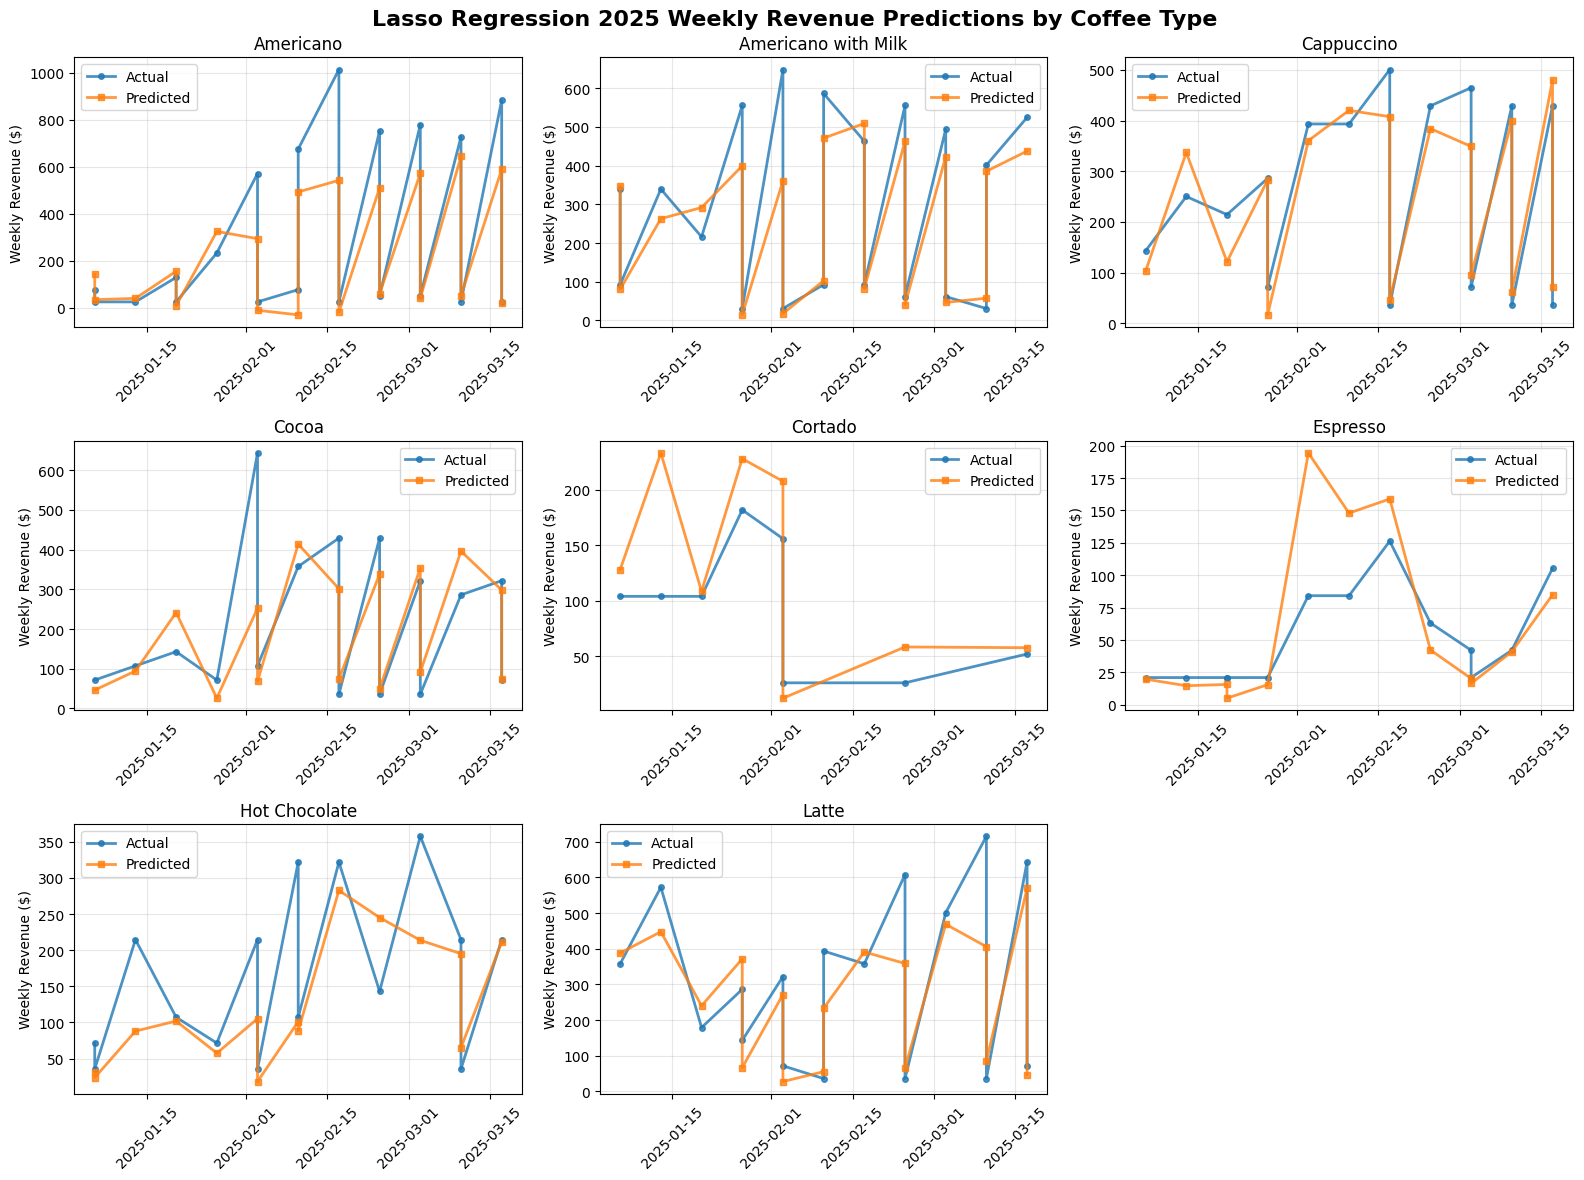

In [ ]:
plot_time_series_predictions(results_lasso_2025, "Lasso Regression")

In [39]:
# Calculate average R² per coffee type for fair comparison
lasso_r2_by_coffee = results_lasso_2025.groupby('coffee_name').apply(
    lambda x: r2_score(x['actual_revenue'], x['predicted_revenue'])
)
lasso_avg_r2 = lasso_r2_by_coffee.mean()

print(f"LightGBM vs Lasso Regression (2025 predictions)")
print(f"")
print(f"Overall Performance:")
print(f"  LightGBM R²: {r2_2025:.3f} | Lasso R²: {r2_lasso_2025:.3f}")
print(f"  LightGBM MAPE: {mape_2025:.1f}% | Lasso MAPE: {mape_lasso_2025:.1f}%")
print(f"")
print(f"Average R² per Coffee Type:")
print(f"  LightGBM: {comparison['combined_r2'].mean():.3f}")
print(f"  Lasso: {lasso_avg_r2:.3f}")
print(f"")
print(f"Average MAPE per Coffee Type:")
print(f"  LightGBM: {coffee_performance_2025['mape_mean'].mean():.1f}%")
print(f"  Lasso: {coffee_performance_lasso_2025['mape_mean'].mean():.1f}%")

LightGBM vs Lasso Regression (2025 predictions)

Overall Performance:
  LightGBM R²: 0.686 | Lasso R²: 0.786
  LightGBM MAPE: 37.4% | Lasso MAPE: 40.4%

Average R² per Coffee Type:
  LightGBM: 0.407
  Lasso: 0.496

Average MAPE per Coffee Type:
  LightGBM: 15.8%
  Lasso: -0.1%


In [40]:
# Feature importance for Lasso (non-zero coefficients)
lasso_coefficients = pd.DataFrame({
    'feature': selected_features,
    'coefficient': lasso_final.coef_,
    'abs_coefficient': np.abs(lasso_final.coef_)
})

# features that weren't zeroed out by Lasso
non_zero_features = lasso_coefficients[lasso_coefficients['abs_coefficient'] > 0].sort_values('abs_coefficient', ascending=False)

print(f"Features selected by Lasso: {len(non_zero_features)} out of {len(selected_features)}")
print(f"\nTop 15 most important features (by absolute coefficient):")
print(non_zero_features.head(15)[['feature', 'coefficient']])

Features selected by Lasso: 15 out of 25

Top 15 most important features (by absolute coefficient):
                           feature  coefficient
12                 hour_of_day_max   164.492809
11                 hour_of_day_min  -148.875762
10                 hour_of_day_std  -132.205365
22     transactions_x_weekend_prop   -37.840313
14                  revenue_4w_std    36.786211
16                 revenue_8w_mean    28.367087
4               prev_3week_revenue   -10.519989
6             dominant_day_of_week     7.019384
8                        month_cos    -5.034940
9         weekend_sales_proportion    -3.835208
3               prev_2week_revenue     3.630410
20        revenue_same_week_4w_ago    -2.372697
24  weekend_proportion_interaction    -1.043703
1                prev_week_revenue     0.978327
21        revenue_same_week_8w_ago     0.730655


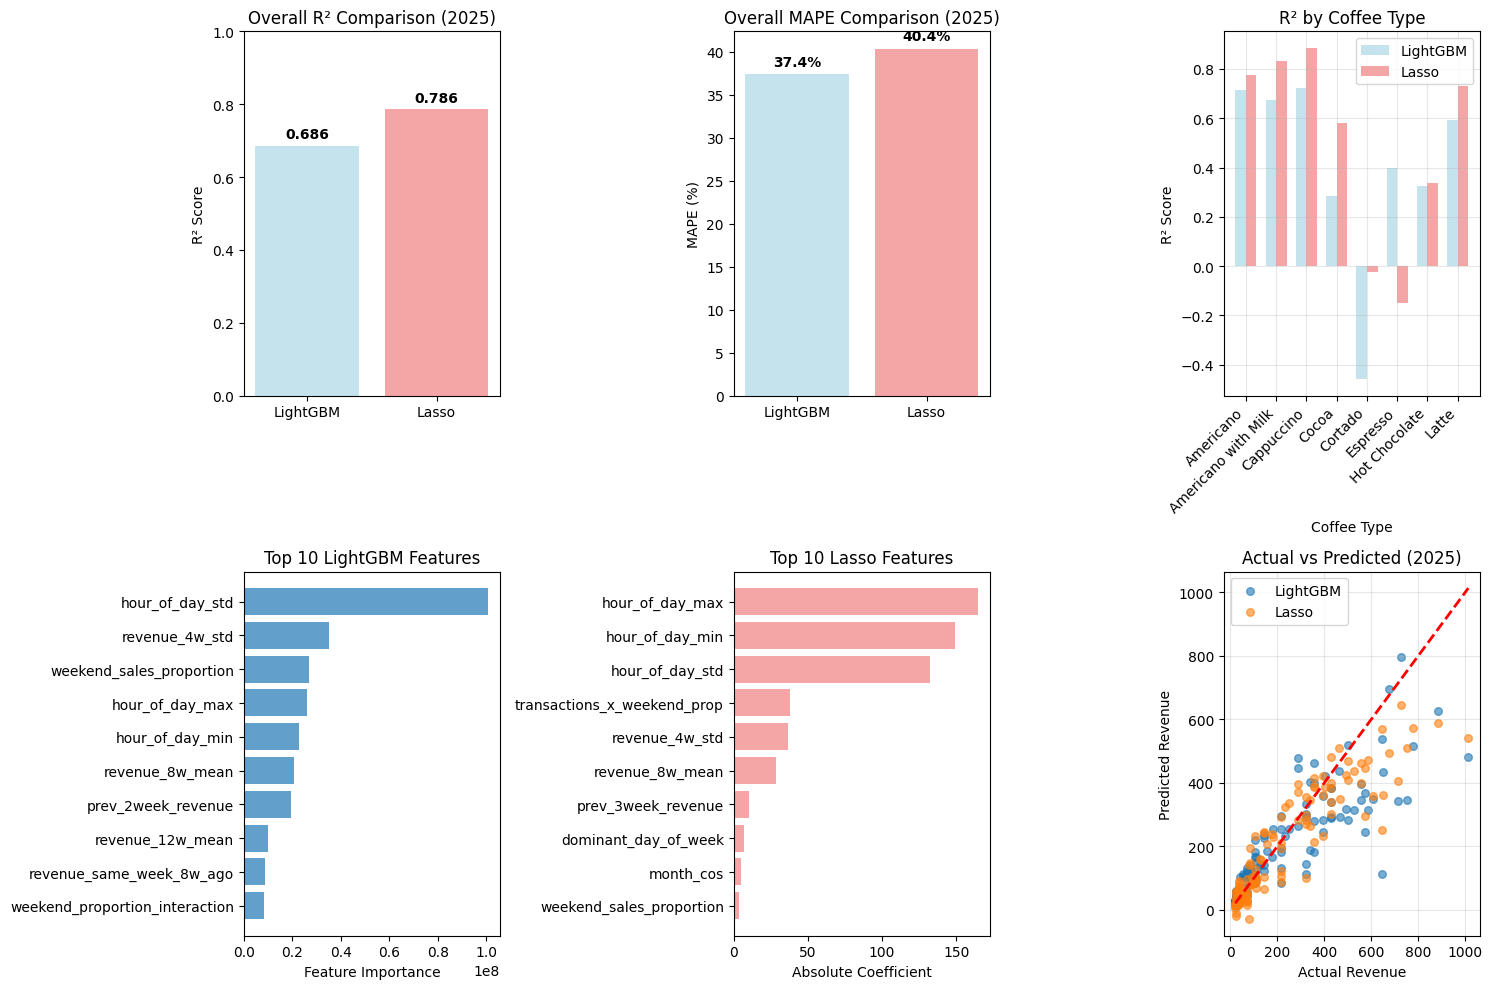

In [41]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
models = ['LightGBM', 'Lasso']
r2_scores = [r2_2025, r2_lasso_2025]
colors = ['lightblue', 'lightcoral']
bars = plt.bar(models, r2_scores, color=colors, alpha=0.7)
plt.ylabel('R² Score')
plt.title('Overall R² Comparison (2025)')
plt.ylim(0, 1)
for i, v in enumerate(r2_scores):
    plt.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

plt.subplot(2, 3, 2)
mape_scores = [mape_2025, mape_lasso_2025]
bars = plt.bar(models, mape_scores, color=colors, alpha=0.7)
plt.ylabel('MAPE (%)')
plt.title('Overall MAPE Comparison (2025)')
for i, v in enumerate(mape_scores):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.subplot(2, 3, 3)
lgb_r2_by_coffee = results_2025.groupby('coffee_name').apply(
    lambda x: r2_score(x['actual_revenue'], x['predicted_revenue'])
)

coffee_names = lgb_r2_by_coffee.index
x_pos = np.arange(len(coffee_names))
width = 0.35

plt.bar(x_pos - width/2, lgb_r2_by_coffee.values, width, label='LightGBM', color='lightblue', alpha=0.7)
plt.bar(x_pos + width/2, lasso_r2_by_coffee.values, width, label='Lasso', color='lightcoral', alpha=0.7)

plt.xlabel('Coffee Type')
plt.ylabel('R² Score')
plt.title('R² by Coffee Type')
plt.xticks(x_pos, coffee_names, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(2, 3, 4)
top_lgb_features = feature_importance.head(10)
top_lasso_features = non_zero_features.head(10)

plt.barh(range(len(top_lgb_features)), top_lgb_features['importance'], alpha=0.7, label='LightGBM')
plt.yticks(range(len(top_lgb_features)), top_lgb_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 10 LightGBM Features')
plt.gca().invert_yaxis()

plt.subplot(2, 3, 5)
plt.barh(range(len(top_lasso_features)), top_lasso_features['abs_coefficient'], alpha=0.7, color='lightcoral')
plt.yticks(range(len(top_lasso_features)), top_lasso_features['feature'])
plt.xlabel('Absolute Coefficient')
plt.title('Top 10 Lasso Features')
plt.gca().invert_yaxis()

plt.subplot(2, 3, 6)
plt.scatter(y_test_lasso, predictions_2025, alpha=0.6, label='LightGBM', s=30)
plt.scatter(y_test_lasso, predictions_lasso_2025, alpha=0.6, label='Lasso', s=30)
plt.plot([y_test_lasso.min(), y_test_lasso.max()], [y_test_lasso.min(), y_test_lasso.max()], 'r--', lw=2)
plt.xlabel('Actual Revenue')
plt.ylabel('Predicted Revenue')
plt.title('Actual vs Predicted (2025)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Comparison Summary
* Lasso performs better overall (R²: 0.786 vs 0.686)
* Lasso is more consistent across coffee types (Avg R²: 0.496 vs 0.407)
* Lasso selected 15 features out of 25
* LightGBM uses complex tree interactions, Lasso uses linear relationships
* Lasso eliminated coffee_encoded, but learns coffee patterns via other indirect features!